<a href="https://colab.research.google.com/github/Efrat-Taig/ControlNet-ColorGrid/blob/main/lora_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training SOTA DreamBooth LoRA Tuning 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) using some of the most popular SOTA methods.

Learn more about the techniques used in this exmaple [here](linke to blogpost)

Let's get started...

## Theroty 🧠

In [ ]:
from IPython.display import Image as IPyImage, display

### DreamBooth
is a fine-tuning technique designed to personalize generative models like Stable Diffusion. It allows users to train the model on a small set of images (e.g., photos of a person, object, or style) and integrate the learned concept into the model’s vocabulary.


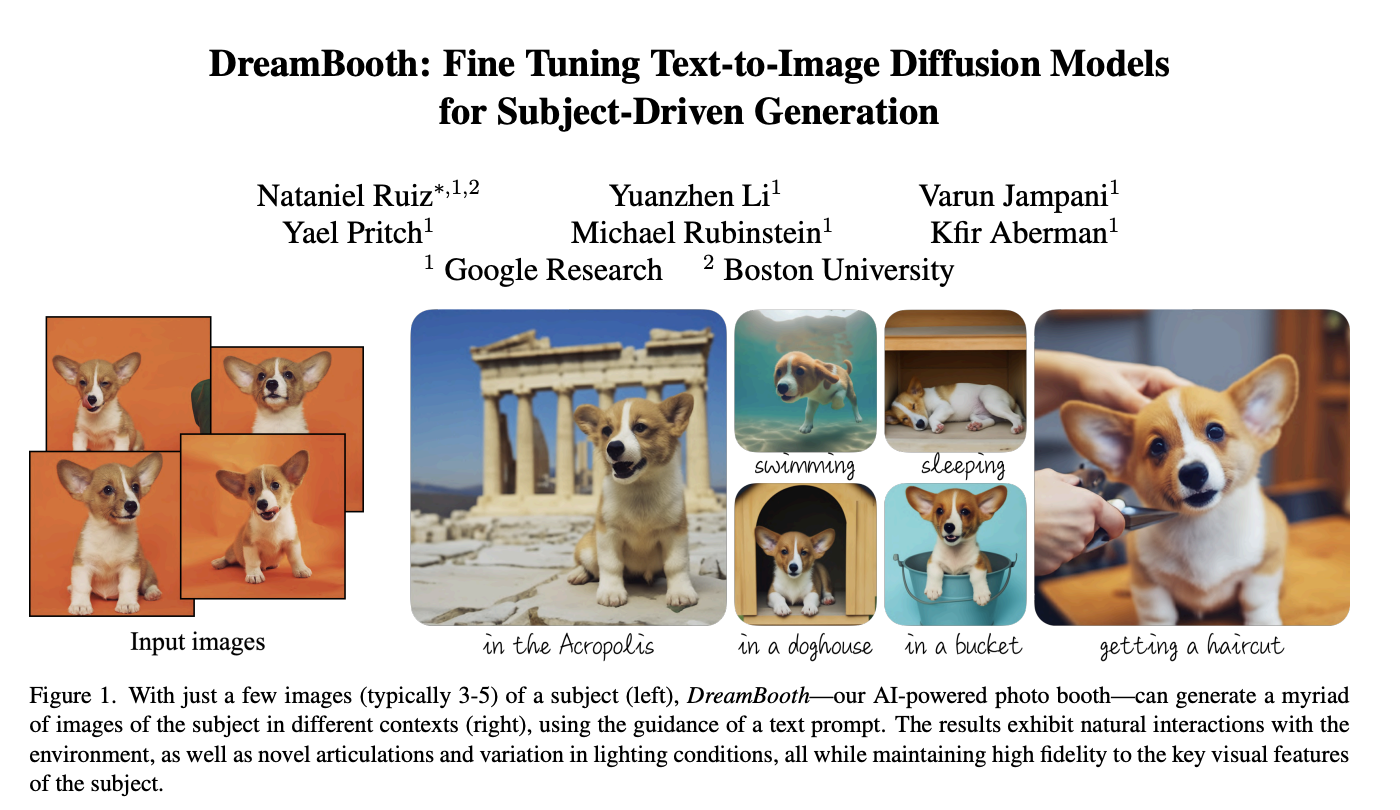

In [ ]:

display(IPyImage("./assets/DreamBooth_header.png", width=1024))

# DreamBooth - https://arxiv.org/pdf/2208.12242


### Low-Rank Approximation

LoRA is a technique to efficiently fine-tune large machine learning models by reducing the number of trainable parameters. Instead of updating the full set of model weights during training, LoRA represents weight updates as the product of two smaller matrices (low-rank matrices).

This approach significantly reduces computational and memory requirements while maintaining high performance, making it particularly useful for large-scale models like transformers. LoRA is widely adopted in applications like NLP and computer vision where fine-tuning massive pre-trained models would otherwise be resource-intensive.

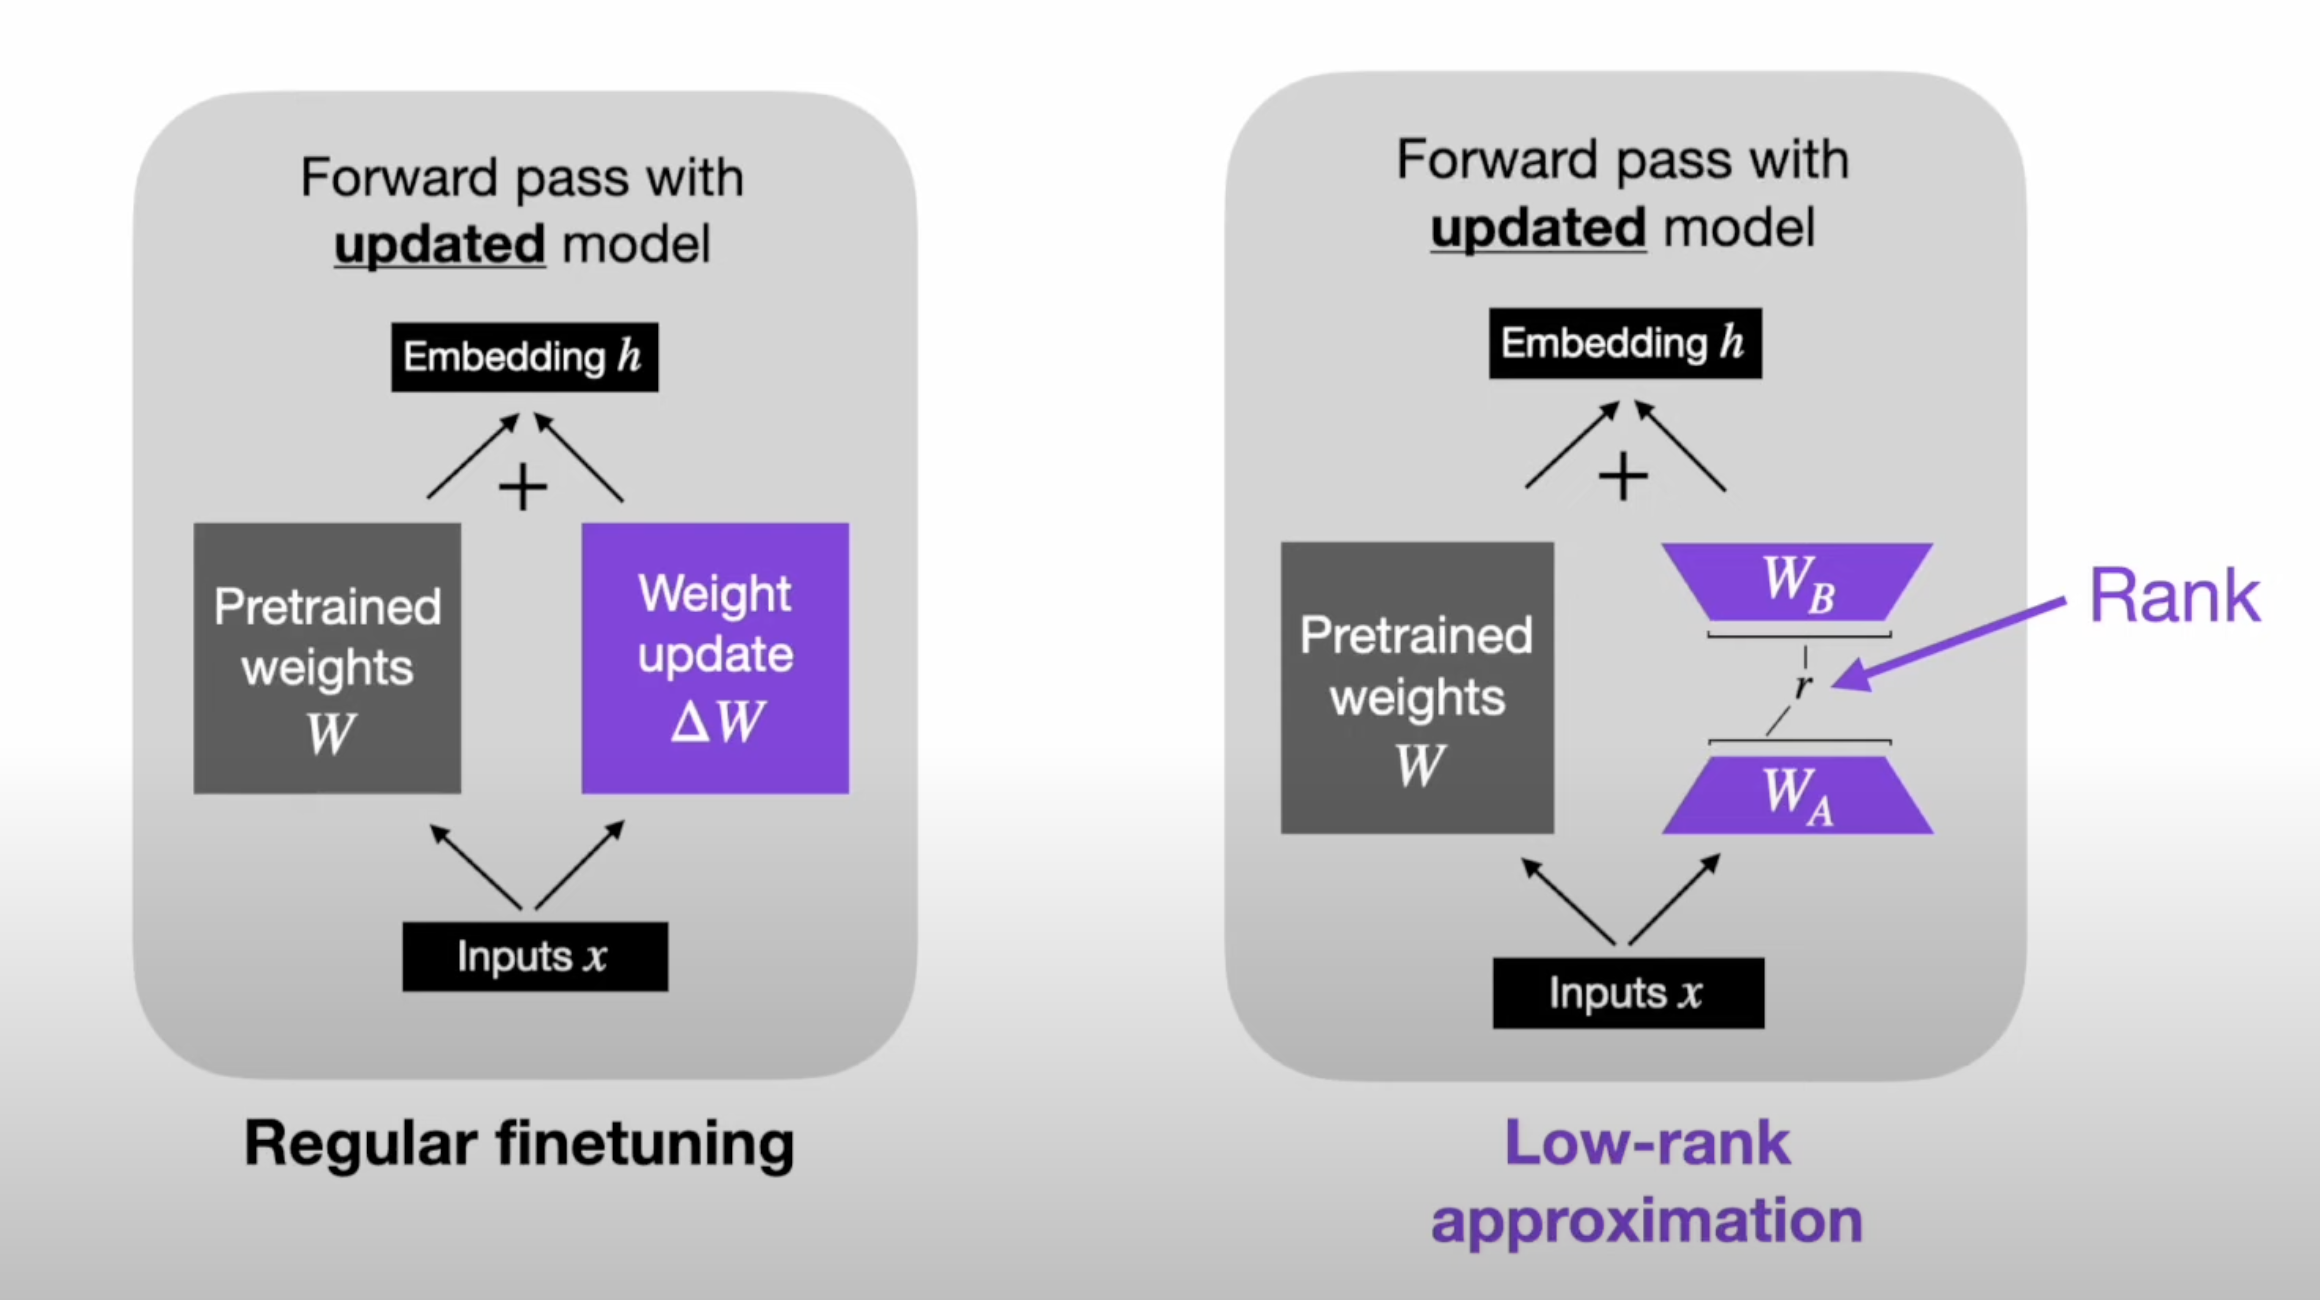

In [ ]:

display(IPyImage("./assets/lora_vs_finetune.png", width=1024))

# LORA - https://arxiv.org/pdf/2106.09685


## Setup 🪓

In [ ]:
# Install dependencies.
%pip install tiktoken xformers bitsandbytes transformers accelerate wandb dadaptation prodigyopt -q
%pip install python-slugify peft -q

# Make sure to install `diffusers` from `main`.
%pip install git+https://github.com/huggingface/diffusers.git -q

%pip install git+https://github.com/huggingface/datasets.git -q

## Dataset 📁

**Let's get our training data!**
For this example, we'll download some images from the hub.

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.

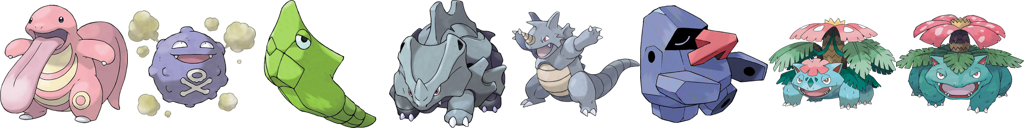

In [ ]:
from datasets import load_dataset
from diffusers.utils import make_image_grid

# Load the dataset
data_set_name = "Bar-Fin/pokemons"

dataset = load_dataset(data_set_name)

sample_number = 8
images = dataset['train'][0:sample_number]["image"]

grid = make_image_grid(images, rows=1, cols=sample_number, resize=128)
grid.show()

### Generate custom captions with LLAVA 🌋

Auto-generating captions for LoRA fine-tuning provides essential supervision by aligning visual and textual features, enriching datasets with descriptive context, improving generalization to unseen data, optimizing task-specific learning, preparing for multimodal applications, and ensuring consistency and scalability across large datasets.

**Note:** In order to trigger the model to generate the style he learned we can use a generl template of `prefix` / `suffix`, this is a prompt engeneering way of telling the model to always applay our learned style and shpould be used in traning and inferance

Feel free to play arround with the template of suffix and prefix as for may usecases there can be more optimal way to describe the outpute e.g:
- For single charecter: A charecter doing ... in retro style
- For clear style: Baroque painting of ...

In [ ]:
prefix = "A pokemon image of"
suffix = "in the style of pokemon"

In [ ]:
from transformers import pipeline, AutoProcessor
from PIL import Image
import torch
import pandas as pd
from IPython.display import display, HTML
from tqdm import tqdm


model_id = "llava-hf/llava-1.5-7b-hf"
pipe = pipeline(
    task="image-to-text",
    model=model_id,
    device="cuda",
    torch_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(model_id)
prompt_instructions = "Elaborate on the image, in your description include details regarding the objects, characters, background, and fine-grained details. Dont start with the image and keep it 10-30 words only."

# Function to generate captions for a single image
def generate_caption(image):
    conversation = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_instructions
                },
                {"type": "image"},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    answer = outputs[0]["generated_text"].split("ASSISTANT:")[1].strip()
    return answer

# Loop over the dataset to generate and save modified captions
def modify_dataset_with_generated_captions(dataset, sample_size=None):
    new_data = []
    for i, item in tqdm(enumerate(dataset)):
        if sample_size and i >= sample_size:
            break
        image = item["image"]
        new_caption = generate_caption(image)


        new_caption_formated = f"{prefix} {new_caption} {suffix}"

        # Store the modified data
        modified_item = {
            **item,  # Keep original data
            "generated_caption": new_caption_formated  # Add new caption
        }
        new_data.append(modified_item)
        # print(f"Processed image {i+1}/{len(dataset)}: {new_caption}")  # Progress indicator
    return new_data


# Modify the dataset (use a smaller sample size for testing)
modified_data = modify_dataset_with_generated_captions(dataset["train"])

# Clean
del processor, pipe


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 
0it [00:00, ?it/s]Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
10it [00:17,  1.83s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
30it [00:47,  1.59s/it]


### Create and visualize you dataset

In [ ]:
from datasets import Dataset, Features, Image as HFImage, Value, DatasetDict, Split


# Visualize dataset in a table
def create_table_with_images(data):
    rows = []
    for i, item in enumerate(data):
        # Extract image and captions
        image = item["image"]
        caption_text = item.get("text", "N/A")
        generated_caption = item.get("generated_caption", "N/A")

        # Save image temporarily for embedding
        image_path = f"temp_image_{i}.png"
        image.save(image_path)

        # Add row with HTML for the image
        rows.append(
            {
                "Image": f'<img src="{image_path}" width="100">',
                "text": caption_text,
                "generated_caption": generated_caption,
            }
        )

    # Create DataFrame
    df = pd.DataFrame(rows)
    # Display DataFrame as HTML
    display(HTML(df.to_html(escape=False, index=False)))


# Define features for the dataset
features = Features({"image": HFImage(), "generated_caption": Value("string")})

# Create individual datasets for train and test
dataset = Dataset.from_list(modified_data, features=features)

# Save the dataset locally
dataset.save_to_disk("./image_caption_dataset")

# Limit the dataset to rows 0:3 (first 3 rows in this case)
limited_dataset = dataset.select(range(0, 5))

# Create and display the table
create_table_with_images(limited_dataset)

Saving the dataset (0/1 shards):   0%|          | 0/30 [00:00<?, ? examples/s]

## Prep for training 🔥

Initialize `accelerate`:

In [ ]:
!accelerate config default

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Configuration already exists at /home/ubuntu/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### Log into your Hugging Face account
Pass [your **read** access token](https://huggingface.co/settings/tokens) it will be used to pull the model from hub:

In [ ]:
from huggingface_hub import login
login(token="...")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


## Train! 🧪

### `Diffusers` 🧨 Training loop

### Launch training 🚀🚀🚀

#### 🤗Pick a name for your Dreambooth LoRA fine-tuned model:🤗
This name will be used to save your model, so pick an informative name based on your chosen concept💡

In [ ]:
from slugify import slugify

model_name = "model_a" # @param
output_dir = slugify(model_name)

**Set your LoRA rank**
The rank of your LoRA is linked to its expressiveness.
The bigger the rank the closer we are to regular dreambooth, and in theory we have more expressive power (and heavier weights).

For a very simple concept that you have a good high quality image set for (e.g. a pet, a generic object), a rank as low as 4 can be enough to get great results. We reccomend going between 8 and 64 depending on your concept and how much of a priortiy it is for you to keep the LoRA small or not.  

In [ ]:
rank = 16 # @param

In [ ]:
# !sudo chown -R $USER /mnt/finetune

Before you start free some memory:

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# --resume_from_checkpoint="latest" \

!accelerate launch \
    --config_file accelerate_config.yaml \
    train_new.py \
    --caption_column="generated_caption" \
    --pretrained_model_name_or_path="briaai/BRIA-2.3" \
    --dataset_name="/home/ubuntu/spring/misc/bar/re-2024/finetune/image_caption_dataset" \
    --resolution=1024 \
    --center_crop \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --gradient_checkpointing \
    --max_train_steps=1000 \
    --checkpointing_steps=200 \
    --use_8bit_adam \
    --learning_rate=1e-04 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --mixed_precision="bf16" \
    --validation_epochs=5 \
    --output_dir="/mnt/re-2024-model-demo-v1" \
    --rank=16


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


11/24/2024 11:31:06 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'rescale_betas_zero_snr', 'variance_type', 'sample_max_value', 'clip_sample', 'thresholding', 'dynamic_thresholding_ratio', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'mid_block_add_attention', 'shift_factor', 'use_post_quant_conv', 'use_quant_conv', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.


## Evaluation 👀

In [ ]:
import torch
from huggingface_hub import hf_hub_download, upload_file
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
from safetensors.torch import load_file

pipe = DiffusionPipeline.from_pretrained("briaai/BRIA-2.3", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
pipe.force_zeros_for_empty_prompt = False

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Benchmarking prompts

In [ ]:
from diffusers.utils import make_image_grid


def generate_images(prompts):
    gen_images = []
    for prompt in prompts:
        image = pipe(prompt=f"{prefix} {prompt} {suffix}", num_inference_steps=25, cross_attention_kwargs={"scale": 1.0}).images[0]
        gen_images.append(image)
    return gen_images

prompts = [
    f"a phoenix pokemon, flyting over a mointain",
    f"a red dragon pokemon, white BG",
    f"a pokemon bird with blue wings, white BG",
    f"a dog pokemon, white BG",
]

In [ ]:

gen_images = generate_images(prompts)
grid = make_image_grid(gen_images, rows=1, cols=len(gen_images), resize=512)
grid.show()


In [ ]:
!ls /mnt/re-2024-model-demo/

checkpoint-1000  checkpoint-600  pytorch_lora_weights.safetensors
checkpoint-200	 checkpoint-800
checkpoint-400	 logs


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

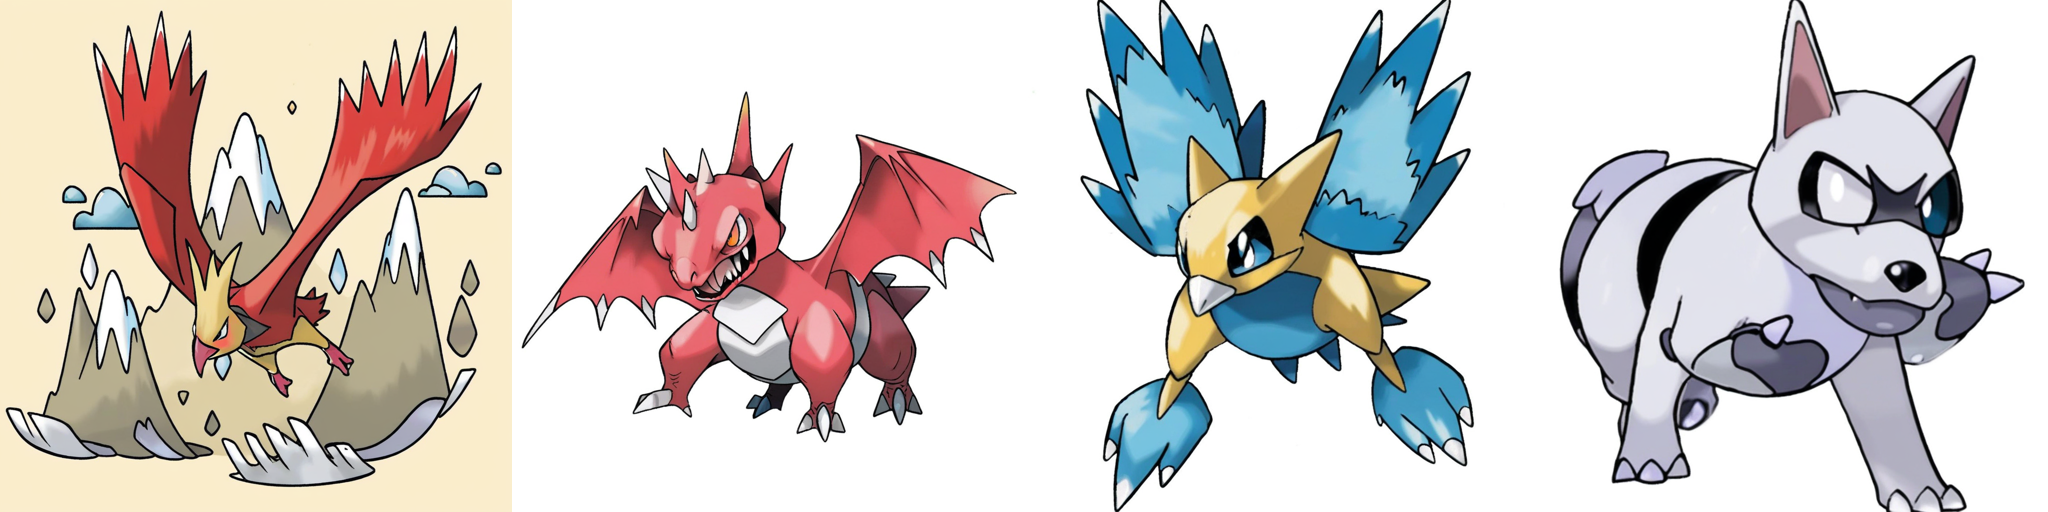

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

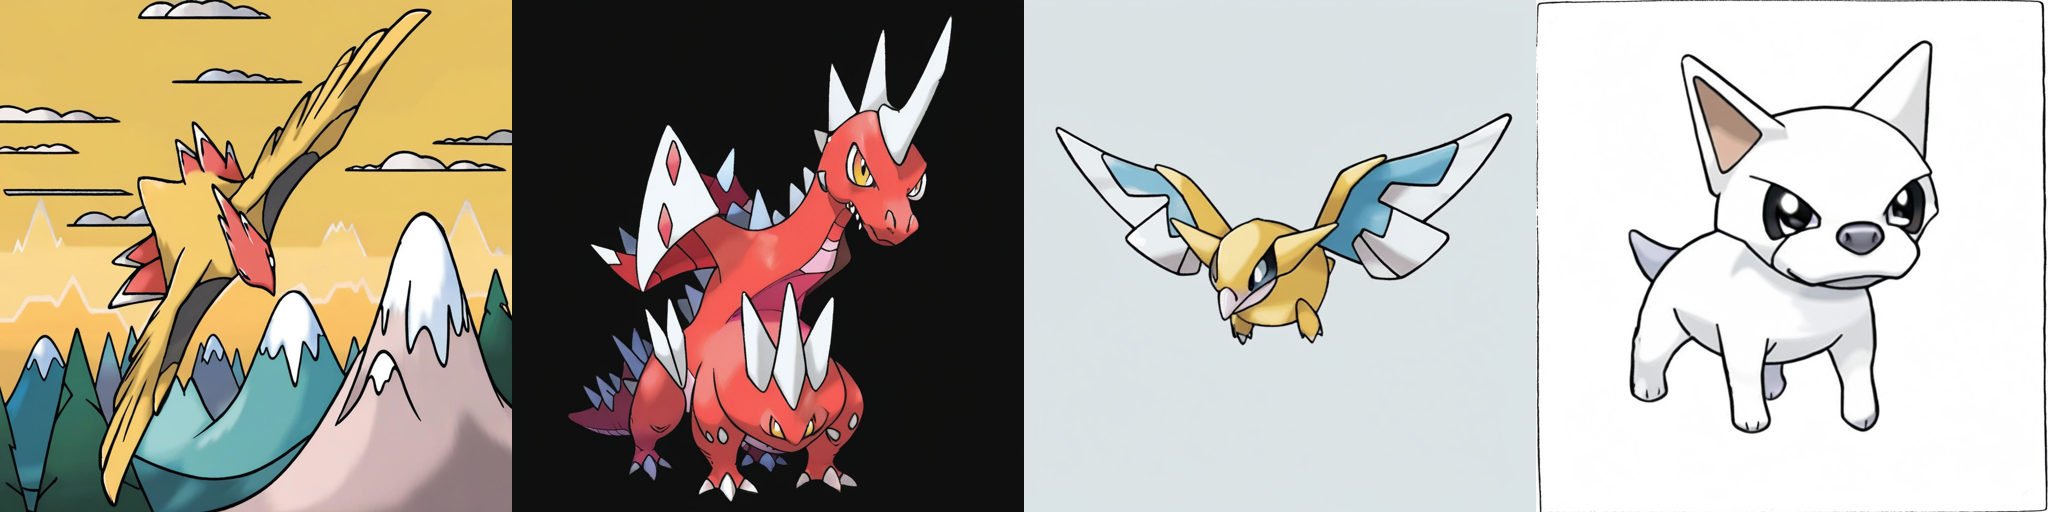

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

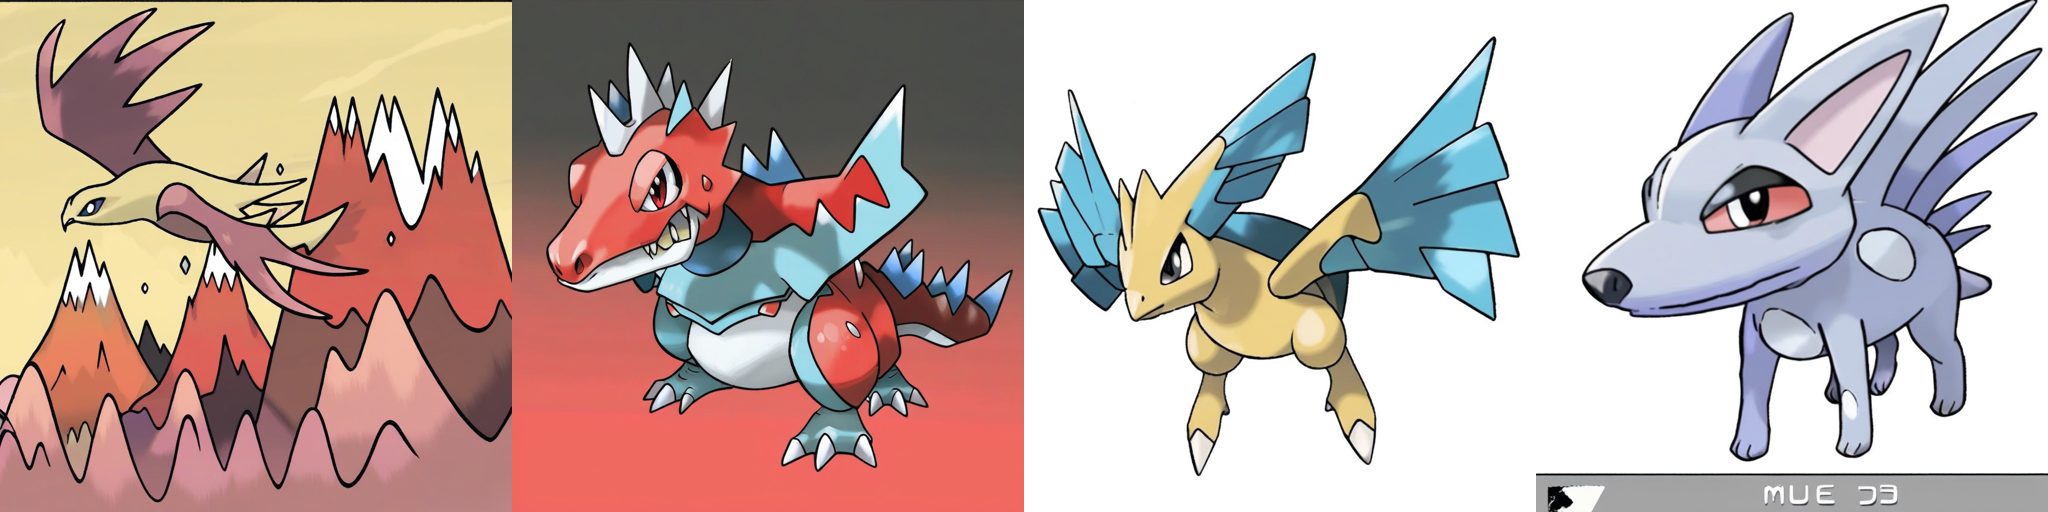

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

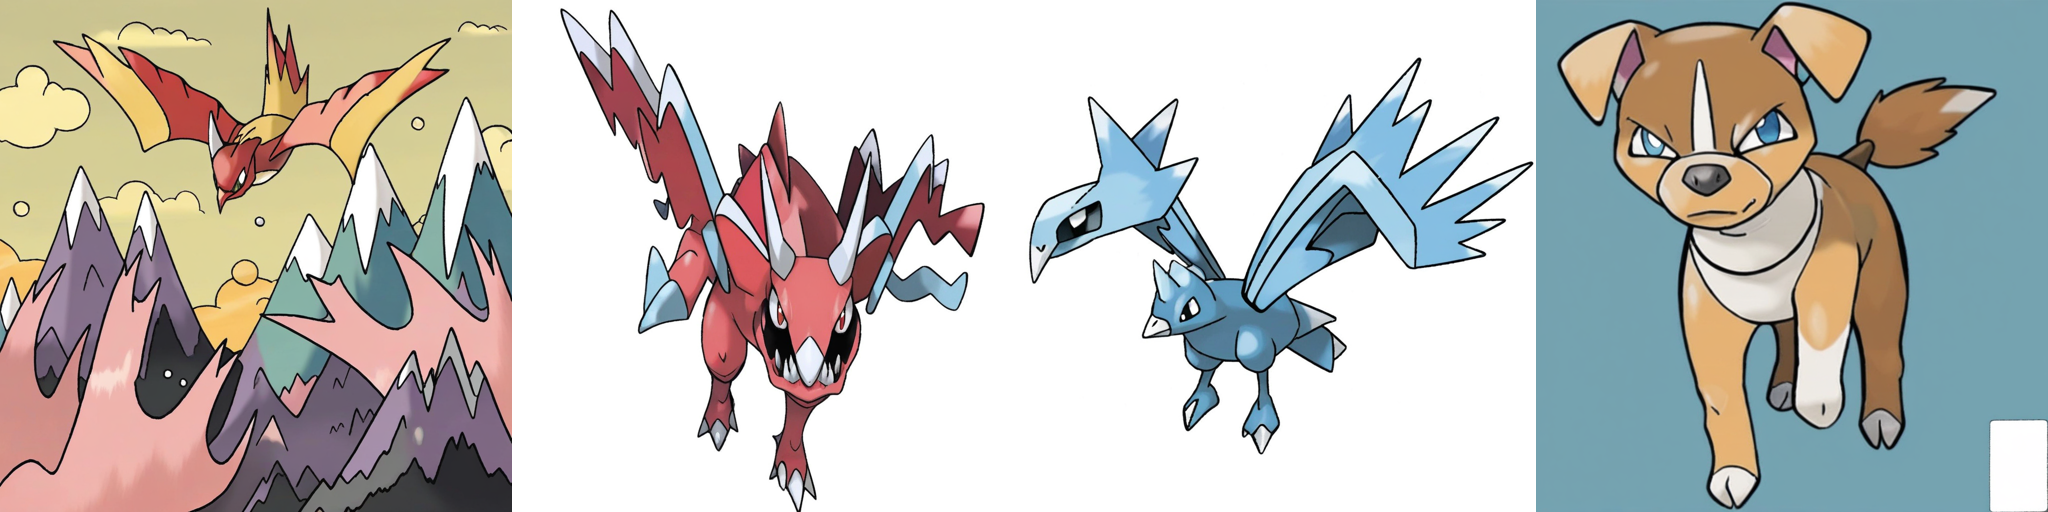

In [ ]:
pipe.load_lora_weights("/mnt/re-2024-model-demo/checkpoint-1000", weight_name="pytorch_lora_weights.safetensors")
images_gens = []
num_of_rows = 4
for _ in range(0, num_of_rows):
    gen_images = generate_images(prompts)
    grid = make_image_grid(gen_images, rows=1, cols=len(gen_images), resize=512)
    grid.show()

In [ ]:
del pipe

## Deploy for inference 🚀

In [ ]:
# bin bash

docker build --target infer_engin -t triton_server .

docker run -d \
	--restart always \
	--gpus=1 \
    --shm-size=4g --ulimit memlock=-1 --ulimit stack=67108864 \
    -p 8000:8000 \
    -p 8001:8001 \
    -v /mnt/models:/mnt/models \
    triton_server \
    tritonserver \
	--strict-model-config=false \
    --model-repository=/mnt/models